In [ ]:
import gymnasium as gym
import numpy as np
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

import pde_opt
from pde_opt.numerics.domains import Domain


In [ ]:
def density(psi):
    return jnp.abs(psi)**2

In [ ]:
def state_to_observation(state):
    _density = density(state[...,0] + 1j*state[...,1])
    return (np.clip(np.array(_density), 0, 0.01) * 255).astype(np.uint8)[None]

In [30]:
def reset_func(domain, seed=0):
    return 0.5 * jnp.ones(domain.points) + 0.01 * random.normal(random.PRNGKey(seed), domain.points)

In [31]:

Nx, Ny = 128, 128
Lx = 0.01 * Nx
Ly = 0.01 * Ny
domain = Domain((Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless")

In [32]:
params = {
    "reset_func": reset_func,
    "diffusion_coefficient": 0.1,
    "max_control_step": 0.1,
    "end_time": 3.0,
    "step_dt": 0.05,
    "numeric_dt": 0.0001,
    "domain": domain,
    "field_dim": 1,
    "reward_function": lambda x: np.var(x),
    "discrete_action_space": True
}

In [33]:
env = gym.make('AdvectionDiffusion-v0', **params)

In [34]:
print(f"Action space: {env.action_space}")  # Discrete(2) - left or right
print(f"Sample action: {env.action_space.sample()}")  # 0 or 1

# Box observation space (continuous values)
print(f"Observation space: {env.observation_space}")  # Box with 4 values
# Box([-4.8, -inf, -0.418, -inf], [4.8, inf, 0.418, inf])

Action space: Discrete(5)
Sample action: 0
Observation space: Box(0, 255, (1, 128, 128), uint8)


In [35]:
# Reset environment to start a new episode
observation, info = env.reset()
# observation: what the agent can "see" - cart position, velocity, pole angle, etc.
# info: extra debugging information (usually not needed for basic learning)


In [36]:
print(observation.shape)

(1, 128, 128)


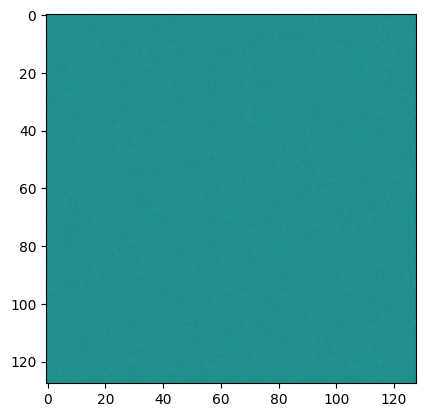

In [37]:
plt.imshow(observation[0], vmin=0, vmax=255)

In [38]:
action = env.action_space.sample()  # Random action for now - real agents will be smarter!

# Take the action and see what happens
observation, reward, terminated, truncated, info = env.step(action)
print(reward)

56.34503307566047


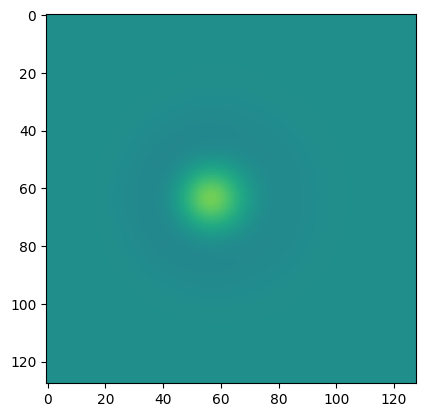

In [39]:
plt.imshow(observation[0], vmin=0, vmax=255)
plt.show()

In [40]:
observation, info = env.reset()

In [41]:
episode_over = False
total_reward = 0

iters = 0

observations = []
while not episode_over:
    print(iters)
    # Choose an action: 0 = push cart left, 1 = push cart right
    action = env.action_space.sample()  # Random action for now - real agents will be smarter!

    # Take the action and see what happens
    observation, reward, terminated, truncated, info = env.step(action)

    # reward: +1 for each step the pole stays upright
    # terminated: True if pole falls too far (agent failed)
    # truncated: True if we hit the time limit (500 steps)

    total_reward += reward
    episode_over = terminated or truncated
    iters += 1
    observations.append(observation[0])

print(f"Episode finished! Total reward: {total_reward}")
env.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
Episode finished! Total reward: 13630.792588889599


In [43]:
from IPython.display import HTML
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(4,4))

ims = []
for i in range(0, len(observations), 2):
    im = ax.imshow(observations[i], animated=True, 
                   vmin=0.0, vmax=255,
                   extent=[domain.box[0][0], domain.box[0][1], 
                          domain.box[1][0], domain.box[1][1]])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

plt.title('Cahn-Hilliard Evolution')
plt.xlabel('x')
plt.ylabel('y')

plt.close()

HTML(ani.to_jshtml())